# Quantitative Trading Strategies Using Python
## Technical Analysis, Statistical Testing,and Machine Learning
—
### Peng Liu

#######################################################################################################################

## CHAPTER 9
## Optimizing Trading Strategies with Bayesian Optimization

### Optimizing the Pairs Trading Strategy

In [ ]:
!pip install botorch
!pip install -U statsmodels
!pip install ta
!pip install yfinance
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition import qExpectedImprovement
from botorch.acquisition import UpperConfidenceBound
from botorch.acquisition.knowledge_gradient import qKnowledgeGradient
from botorch.fit import fit_gpytorch_mll
from bs4 import BeautifulSoup
from datetime import datetime
from dateutil.relativedelta import relativedelta
from itertools import combinations
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
import requests
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import ta
import torch
import torch.nn as nn
import yfinance as yf

In [ ]:
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

### Trading Strategy Performance As the Black-Box Function

In [ ]:
# Defining the black-box function for Bayesian optimization
class QTS_OPTIMIZER(nn.Module):
    def __init__(self, ticker_pair, start_date, end_date, riskfree_rate=0.04):
        super(QTS_OPTIMIZER, self).__init__()
        self.ticker_pair = ticker_pair
        self.start_date = start_date
        self.end_date = end_date
        self.riskfree_rate = riskfree_rate
        self.stock = self.get_stock_data()
   
    # Defining the method to retrieve stock data
    def get_stock_data(self):
        print("===== DOWNLOADING STOCK DATA =====")
        df = yf.download(self.ticker_pair, start=self.start_date, end=self.end_date)['Adj Close']
        print("===== DOWNLOAD COMPLETE =====")
        return pd.DataFrame(df)
    
    # Defining the method to calculate the Sharpe ratio
    def forward(self, entry_threshold, exit_threshold, window_size=10):
        # add sma columns
        stock_df = self.stock.copy()
        # calculate the spread for GOOG and MSFT
        Y = stock_df[self.ticker_pair[0]]
        X = stock_df[self.ticker_pair[1]]
        # estimate linear regression coefficients
        X_with_constant = sm.add_constant(X)
        model = OLS(Y, X_with_constant).fit()
        # obtain the spread as the residuals
        spread = Y - model.predict()
        # calculate rolling mean and sd
        spread_mean = spread.rolling(window=window_size).mean()
        spread_std = spread.rolling(window=window_size).std()
        zscore = (spread - spread_mean) / spread_std
        # remove initial days with NA
        first_valid_idx = zscore.first_valid_index()
        zscore = zscore[first_valid_idx:]
        # initialize the daily positions to be zeros
        stock1_position = pd.Series(data=0, index=zscore.index)
        stock2_position = pd.Series(data=0, index=zscore.index)
        # generate daily entry and exit signals for each stock
        for i in range(1, len(zscore)):
        # zscore<-entry_threshold and no existing long position for stock 1
            if zscore[i] < -entry_threshold and stock1_position[i-1] == 0:
                stock1_position[i] = 1 # long stock 1
                stock2_position[i] = -1 # short stock 2
        # zscore>entry_threshold and no existing short positionfor stock 2
            elif zscore[i] > entry_threshold and stock2_position[i-1] == 0:
                stock1_position[i] = -1 # short stock 1
                stock2_position[i] = 1 # long stock 2
        # -exit_threshold<zscore<exit_threshold
            elif abs(zscore[i]) < exit_threshold:
                stock1_position[i] = 0 # exit existing position
                stock2_position[i] = 0
        # -entry_threshold<zscore<-exit_threshold or exit_threshold<zscore<entry_threshold
            else:
                stock1_position[i] = stock1_position[i-1] # maintain existing position
                stock2_position[i] = stock2_position[i-1]
        # Calculate the returns of each stock
        stock1_returns = (Y[first_valid_idx:].pct_change() * stock1_position.shift(1)).fillna(0)
        stock2_returns = (X[first_valid_idx:].pct_change() * stock2_position.shift(1)).fillna(0)
        # calculate the total returns of the strategy
        total_returns = stock1_returns + stock2_returns
        # calculate annualized return
        annualized_return = (1 + total_returns).prod()**(252/Y[first_valid_idx:].shape[0])-1
        # calculate annualized volatility
        annualized_vol = total_returns.std()*(252**0.5)
        if annualized_vol==0:
                annualized_vol = 100
        # calculate Sharpe ratio
        sharpe_ratio = (annualized_return - self.riskfree_rate) /annualized_vol
        
        return sharpe_ratio

In [ ]:
qts = QTS_OPTIMIZER(ticker_pair=['GOOG','MSFT'], start_date="2022-01-01", end_date="2023-01-01")

[*********************100%%**********************]  2 of 2 completed

===== DOWNLOADING STOCK DATA =====
===== DOWNLOAD COMPLETE =====


In [ ]:
qts.stock.head()

Ticker,GOOG,MSFT
Date,,
2022-01-03,144.909592,327.530151
2022-01-04,144.252350,321.913879
2022-01-05,137.497040,309.556305
2022-01-06,137.394653,307.110199
2022-01-07,136.848770,307.266754


In [ ]:
qts(entry_threshold=2, exit_threshold=1)

/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_2743/1385972863.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore[i] < -entry_threshold and stock1_position[i-1] == 0:
/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_2743/1385972863.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif zscore[i] > entry_threshold and stock2_position[i-1] == 0:
/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_2743/1385972863.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with

1.690519309168858

In [ ]:
qts(entry_threshold=1.5, exit_threshold=0.5)

/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_2743/1385972863.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore[i] < -entry_threshold and stock1_position[i-1] == 0:
/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_2743/1385972863.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif zscore[i] > entry_threshold and stock2_position[i-1] == 0:
/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_2743/1385972863.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with

1.8278357656432205

### Generating Training Set for Bayesian Optimization

In [ ]:
# generate initial training dataset for optimization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
x1_bound = [1,3]
x2_bound = [0,1]

In [ ]:
def generate_initial_data(n=10):
    # generate random initial locations
    train_x1 = x1_bound[0] + (x1_bound[1] - x1_bound[0]) * torch.rand(size=(n,1), device=device, dtype=dtype)
    train_x2 = torch.rand(size=(n,1), device=device, dtype=dtype)
    train_x = torch.cat((train_x1, train_x2), 1)
     # obtain the exact value of the objective function and add output dimension
    train_y = []
    for i in range(len(train_x)):
        train_y.append(qts(entry_threshold=train_x1[i], exit_threshold=train_x2[i]))
    train_y = torch.Tensor(train_y, device=device).to(dtype).unsqueeze(-1)
    # get the current best observed value, i.e., utility of the available dataset
    best_observed_value = train_y.max().item()
    return train_x, train_y, best_observed_value

In [ ]:
train_x, train_y, best_observed_value = generate_initial_data(n=3)

/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_2743/1385972863.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore[i] < -entry_threshold and stock1_position[i-1] == 0:
/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_2743/1385972863.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif zscore[i] > entry_threshold and stock2_position[i-1] == 0:
/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_2743/1385972863.py:48: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with

In [ ]:
print(train_x)


tensor([[1.1221, 0.1771],
        [1.4491, 0.5561],
        [1.4685, 0.1094]], dtype=torch.float64)


In [ ]:
print(train_y)


tensor([[0.0550],
        [2.2504],
        [1.0004]], dtype=torch.float64)


In [ ]:
print(best_observed_value)

2.2503504753112793


### Implementing the Gaussian Process Model

##### initialize GP model

In [ ]:
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
def initialize_model(train_x, train_y):
    # create a single-task exact GP model instance
    #  use a GP prior with Matern kernel and constant mean functionby default
    model = SingleTaskGP(train_X=train_x, train_Y=train_y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

/Users/jas3540/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
mll, model = initialize_model(train_x, train_y)
list(model.named_hyperparameters())

/Users/jas3540/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/jas3540/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.1019], dtype=torch.float64), std = tensor([1.1012], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([2.0000], dtype=torch.float64, requires_grad=True)),
 ('mean_module.raw_constant',
  Parameter containing:
  tensor(0., dtype=torch.float64, requires_grad=True)),
 ('covar_module.raw_outputscale',
  Parameter containing:
  tensor(0., dtype=torch.float64, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[0., 0.]], dtype=torch.float64, requires_grad=True))]

##### optimize GP hyperparameters

In [ ]:
# fit hyperparameters (kernel parameters and noise variance) of a GPyTorch model
fit_gpytorch_mll(mll.cpu());
mll = mll.to(train_x)
model = model.to(train_x)
list(model.named_hyperparameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([0.2238], dtype=torch.float64, requires_grad=True)),
 ('mean_module.raw_constant',
  Parameter containing:
  tensor(1.1789, dtype=torch.float64, requires_grad=True)),
 ('covar_module.raw_outputscale',
  Parameter containing:
  tensor(1.8916, dtype=torch.float64, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[-0.8823, -0.9687]], dtype=torch.float64, requires_grad=True))]

### Guiding the Sequential Search by Maximizing the Acquisition Function

##### Define acquisition function

In [ ]:
# call helper functions to generate initial training data and initialize model
train_x, train_y, best_observed_value = generate_initial_data(n=3)
train_x_ei = train_x
train_x_qei = train_x
train_x_ucb = train_x
train_x_qkg = train_x
train_y_ei = train_y
train_y_qei = train_y
train_y_ucb = train_y
train_y_qkg = train_y

/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_2743/1385972863.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore[i] < -entry_threshold and stock1_position[i-1] == 0:
/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_2743/1385972863.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif zscore[i] > entry_threshold and stock2_position[i-1] == 0:
/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_2743/1385972863.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with

In [ ]:
mll_ei, model_ei = initialize_model(train_x_ei, train_y_ei)
mll_qei, model_qei = initialize_model(train_x_qei, train_y_qei)
mll_ucb, model_ucb = initialize_model(train_x_ucb, train_y_ucb)
mll_qkg, model_qkg = initialize_model(train_x_qkg, train_y_qkg)

/Users/jas3540/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/jas3540/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.7379], dtype=torch.float64), std = tensor([0.5814], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [ ]:
EI = ExpectedImprovement(model=model_ei, best_f=best_observed_value)
qEI = qExpectedImprovement(model=model_qei, best_f=best_observed_value)
beta = 0.8
UCB = UpperConfidenceBound(model=model_ucb, beta=beta)
num_fantasies = 64
qKG = qKnowledgeGradient(
    model=model_qkg,
    num_fantasies=num_fantasies,
    # X_baseline=train_x,
    # q=1
)

##### Obtaining a new proposal by optimizing the acquisition function

In [ ]:
# optimize and get new observation
from botorch.optim import optimize_acqf
# get search bounds
bounds = torch.tensor([[x1_bound[0], x2_bound[0]], [x1_bound[1], x2_bound[1]]], device=device, dtype=dtype)
# parallel candidate locations generated in each iteration
BATCH_SIZE = 1
# number of starting points for multistart optimization
NUM_RESTARTS = 10
# number of samples for initialization
RAW_SAMPLES = 1024
def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    # optimize
    candidates, value = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES, # used for intialization heuristic
    )
    # observe new values
    new_x = candidates.detach()
    # sample output value
    new_y = qts(entry_threshold=new_x.squeeze()[0].item(), exit_threshold=new_x.squeeze()[1].item())
    # add output dimension
    new_y = torch.Tensor([new_y], device=device).to(dtype).unsqueeze(-1)
    # print("new fn value:", new_y)
    return new_x, new_y

In [ ]:
optimize_acqf_and_get_observation(qKG)

/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_2743/1385972863.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore[i] < -entry_threshold and stock1_position[i-1] == 0:
/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_2743/1385972863.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif zscore[i] > entry_threshold and stock2_position[i-1] == 0:
/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_2743/1385972863.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with

(tensor([[1.5470, 0.6003]], dtype=torch.float64),
 tensor([[2.2481]], dtype=torch.float64))

##### Defining the random search strategy

In [ ]:
def update_random_observations(best_random):
    """Simulates a random policy by drawing a new random points,
     observing their values, and updating the current best candidate to the running list."""
    new_x1 = x1_bound[0] + (x1_bound[1] - x1_bound[0]) * torch.rand(size=(1,1), device=device, dtype=dtype)
    new_x2 = torch.rand(size=(1,1), device=device, dtype=dtype)
    new_x = torch.cat((new_x1, new_x2), 1)
    new_y = qts(entry_threshold=new_x[0,0].item(), exit_threshold=new_x[0,1].item())
    best_random.append(max(best_random[-1], new_y))
    return best_random

### Performing Sequential Search

/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_2743/1385972863.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore[i] < -entry_threshold and stock1_position[i-1] == 0:
/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_2743/1385972863.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif zscore[i] > entry_threshold and stock2_position[i-1] == 0:
/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_2743/1385972863.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with

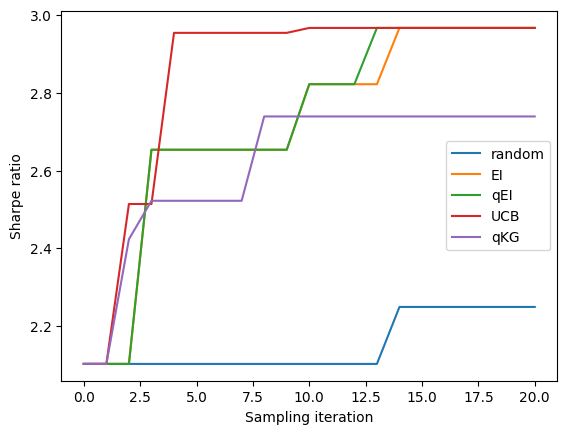

In [ ]:
# single trial
import time
N_ROUND = 20
verbose = True
beta = 0.8
best_random, best_observed_ei, best_observed_qei, best_observed_ucb, best_observed_qkg = [], [], [], [], []
best_random.append(best_observed_value)
best_observed_ei.append(best_observed_value)
best_observed_qei.append(best_observed_value)
best_observed_ucb.append(best_observed_value)
best_observed_qkg.append(best_observed_value)
# run N_ROUND rounds of BayesOpt after the initial random batch
for iteration in range(1, N_ROUND + 1):
    t0 = time.monotonic()
    # fit the models
    fit_gpytorch_mll(mll_ei)
    fit_gpytorch_mll(mll_qei)
    fit_gpytorch_mll(mll_ucb)
    fit_gpytorch_mll(mll_qkg)
    # for best_f, we use the best observed exact values
    EI = ExpectedImprovement(model=model_ei, best_f=train_y_ei.max())
    qEI = qExpectedImprovement(model=model_qei,
        best_f=train_y_ei.max(),
        # num_samples=1024
    )
    UCB = UpperConfidenceBound(model=model_ucb, beta=beta)
    qKG = qKnowledgeGradient(
        model=model_qkg,
        num_fantasies=64,
        objective=None,
        # X_baseline=train_x_qkg,
    )
    # optimize and get new observation
    new_x_ei, new_y_ei = optimize_acqf_and_get_observation(EI)
    new_x_qei, new_y_qei = optimize_acqf_and_get_observation(qEI)
    new_x_ucb, new_y_ucb = optimize_acqf_and_get_observation(UCB)
    new_x_qkg, new_y_qkg = optimize_acqf_and_get_observation(qKG)
    # update training points
    train_x_ei = torch.cat([train_x_ei, new_x_ei], dim=0)
    train_x_qei = torch.cat([train_x_qei, new_x_qei], dim=0)
    train_x_ucb = torch.cat([train_x_ucb, new_x_ucb], dim=0)
    train_x_qkg = torch.cat([train_x_qkg, new_x_qkg], dim=0)
    train_y_ei = torch.cat([train_y_ei, new_y_ei], dim=0)
    train_y_qei = torch.cat([train_y_qei, new_y_qei], dim=0)
    train_y_ucb = torch.cat([train_y_ucb, new_y_ucb], dim=0)
    train_y_qkg = torch.cat([train_y_qkg, new_y_qkg], dim=0)

    # update progress
    best_random = update_random_observations(best_random)
    best_value_ei = max(best_observed_ei[-1], new_y_ei.item())
    best_value_qei = max(best_observed_qei[-1], new_y_qei.item())
    best_value_ucb = max(best_observed_ucb[-1], new_y_ucb.item())
    best_value_qkg = max(best_observed_qkg[-1], new_y_qkg.item())
    best_observed_ei.append(best_value_ei)
    best_observed_qei.append(best_value_qei)
    best_observed_ucb.append(best_value_ucb)
    best_observed_qkg.append(best_value_qkg)
    # reinitialize the models so they are ready for fitting on nextiteration
    mll_ei, model_ei = initialize_model(
        train_x_ei,
        train_y_ei
    )
    mll_qei, model_qei = initialize_model(
        train_x_qei,
        train_y_qei
    )
    mll_ucb, model_ucb = initialize_model(
        train_x_ucb,
        train_y_ucb
    )
    mll_qkg, model_qkg = initialize_model(
        train_x_qkg,
        train_y_qkg
    )
    t1 = time.monotonic()
# Let us plot the search progress so far via the following code snippet:
iters = np.arange(N_ROUND + 1) * BATCH_SIZE
plt.plot(iters, best_random, label='random')
plt.plot(iters, best_observed_ei, label='EI')

plt.plot(iters, best_observed_qei, label='qEI')
plt.plot(iters, best_observed_ucb, label='UCB')
plt.plot(iters, best_observed_qkg, label='qKG')
plt.legend()
plt.xlabel("Sampling iteration")
plt.ylabel("Sharpe ratio")
plt.show()

##### Assessing the stability of the results via repeated experiments

In [ ]:
# multiple trials
# number of runs to assess std of different BO loops
N_TRIALS = 4
# indicator to print diagnostics
verbose = True
# number of steps in the outer BO loop
N_ROUND = 20
best_random_all, best_observed_ei_all, best_observed_qei_all, best_observed_ucb_all, best_observed_qkg_all = [], [], [], [], []
# average over multiple trials
for trial in range(1, N_TRIALS + 1):
    best_random, best_observed_ei, best_observed_qei, best_observed_ucb,best_observed_qkg = [], [], [], [], []
    # call helper functions to generate initial training data and initialize model
    train_x, train_y, best_observed_value = generate_initial_data(n=3)
    train_x_ei = train_x
    train_x_qei = train_x
    train_x_ucb = train_x
    train_x_qkg = train_x
    train_y_ei = train_y
    train_y_qei = train_y
    train_y_ucb = train_y
    train_y_qkg = train_y
    mll_ei, model_ei = initialize_model(train_x_ei, train_y_ei)
    mll_qei, model_qei = initialize_model(train_x_qei, train_y_qei)
    mll_ucb, model_ucb = initialize_model(train_x_ucb, train_y_ucb)
    mll_qkg, model_qkg = initialize_model(train_x_qkg, train_y_qkg)
    best_random.append(best_observed_value)
    
    best_observed_ei.append(best_observed_value)
    best_observed_qei.append(best_observed_value)
    best_observed_ucb.append(best_observed_value)
    best_observed_qkg.append(best_observed_value)
    # run N_ROUND rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_ROUND + 1):
        t0 = time.monotonic()
        # fit the models
        fit_gpytorch_mll(mll_ei)
        fit_gpytorch_mll(mll_qei)
        fit_gpytorch_mll(mll_ucb)
        fit_gpytorch_mll(mll_qkg)
        # for best_f, we use the best observed exact values
        EI = ExpectedImprovement(model=model_ei, best_f=train_y_ei.max())
        qEI = qExpectedImprovement(model=model_qei,
                                    best_f=train_y_ei.max(),
                                    # num_samples=1024
        )
        UCB = UpperConfidenceBound(model=model_ucb, beta=beta)
        qKG = qKnowledgeGradient(
            model=model_qkg,
            num_fantasies=64,
            objective=None,
            # X_baseline=train_x_qkg,
        )
        # optimize and get new observation
        new_x_ei, new_y_ei = optimize_acqf_and_get_observation(EI)
        new_x_qei, new_y_qei = optimize_acqf_and_get_observation(qEI)
        new_x_ucb, new_y_ucb = optimize_acqf_and_get_observation(UCB)
        new_x_qkg, new_y_qkg = optimize_acqf_and_get_observation(qKG)
        # update training points
        train_x_ei = torch.cat([train_x_ei, new_x_ei], dim=0)
        train_x_qei = torch.cat([train_x_qei, new_x_qei], dim=0)
        train_x_ucb = torch.cat([train_x_ucb, new_x_ucb], dim=0)

        train_x_qkg = torch.cat([train_x_qkg, new_x_qkg], dim=0)
        train_y_ei = torch.cat([train_y_ei, new_y_ei], dim=0)
        train_y_qei = torch.cat([train_y_qei, new_y_qei], dim=0)
        train_y_ucb = torch.cat([train_y_ucb, new_y_ucb], dim=0)
        train_y_qkg = torch.cat([train_y_qkg, new_y_qkg], dim=0)
        # update progress
        best_random = update_random_observations(best_random)
        best_value_ei = max(best_observed_ei[-1], new_y_ei.item())
        best_value_qei = max(best_observed_qei[-1], new_y_qei.item())
        best_value_ucb = max(best_observed_ucb[-1], new_y_ucb.item())
        best_value_qkg = max(best_observed_qkg[-1], new_y_qkg.item())
        best_observed_ei.append(best_value_ei)
        best_observed_qei.append(best_value_qei)
        best_observed_ucb.append(best_value_ucb)
        best_observed_qkg.append(best_value_qkg)
        # reinitialize the models so they are ready for fitting on next iteration
        mll_ei, model_ei = initialize_model(
        train_x_ei,
        train_y_ei
        )
        mll_qei, model_qei = initialize_model(
        train_x_qei,
        train_y_qei
        )
        mll_ucb, model_ucb = initialize_model(
        train_x_ucb,
        train_y_ucb
        )
        mll_qkg, model_qkg = initialize_model(
        train_x_qkg,
        train_y_qkg
        )

        t1 = time.monotonic()
    best_observed_ei_all.append(best_observed_ei)
    best_observed_qei_all.append(best_observed_qei)
    best_observed_ucb_all.append(best_observed_ucb)
    best_observed_qkg_all.append(best_observed_qkg)
    best_random_all.append(best_random)


/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_2743/1385972863.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore[i] < -entry_threshold and stock1_position[i-1] == 0:
/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_2743/1385972863.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif zscore[i] > entry_threshold and stock2_position[i-1] == 0:
/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_2743/1385972863.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with

##### Extracting the mean and standard deviation for all experiments

In [ ]:
def extract_last_entry(x):
    tmp = []
    for i in range(4):
        tmp.append(x[i][-1])
    return tmp

rst_df = pd.DataFrame({
    "EI": [np.mean(extract_last_entry(best_observed_ei_all)),
np.std(extract_last_entry(best_observed_ei_all))],
    "qEI": [np.mean(extract_last_entry(best_observed_qei_all)),
np.std(extract_last_entry(best_observed_qei_all))],
    "UCB": [np.mean(extract_last_entry(best_observed_ucb_all)),
np.std(extract_last_entry(best_observed_ucb_all))],
    "qKG": [np.mean(extract_last_entry(best_observed_qkg_all)),
np.std(extract_last_entry(best_observed_qkg_all))],
    "random": [np.mean(extract_last_entry(best_random_all)),
np.std(extract_last_entry(best_random_all))],
}, index=["mean", "std"])

rst_df

,EI,qEI,UCB,qKG,random
mean,2.864523,2.721205,2.754334,2.823814,2.435800
std,0.102312,0.076370,0.024159,0.088935,0.027915


####################################################################################################################################